In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.omniwheel_calculation import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import polars as pl
from tqdm import tqdm

from support.calculations_support import *
from support.ar_calculations import *
from numba import njit

Defining paths of folders

In [31]:
_parent_folder = "omni_cam_9d0f_may_8_2023"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)

#open the calibration files
_folder_name = "sk36_30_random_01"
_calibration_folder = "calibration_00"

_pth = os.path.join(_base_pth, _folder_name)
_calib_pth = os.path.join(_base_pth, _calibration_folder)

Reading mocap data

In [32]:
mc_df_pth = os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv")
_m_df, st_time = read_rigid_body_csv(mc_df_pth)
_m_df = add_datetime_col(_m_df, st_time, _name="seconds")

Mocap preprocessing

In [33]:
# Mocap markers in aruco plate
_ar_tr = get_rb_marker_name(7)
_ar_tl = get_rb_marker_name(2)
_ar_br = get_rb_marker_name(3)
_ar_bl = get_rb_marker_name(1)

# mocap markers in center of the robot
_xm = get_rb_marker_name(6)
_ym = get_rb_marker_name(4)
_om = get_rb_marker_name(8)

Ground truth for aruco marker

In [34]:
_mocap_ar = pd.DataFrame()
_mocap_ar["time"] = _m_df["time"]
_mocap_ar["x"] = _m_df[_ar_tr["x"]] + _m_df[_ar_tl["x"]] + _m_df[_ar_br["x"]] + _m_df[_ar_bl["x"]]
_mocap_ar["y"] = _m_df[_ar_tr["y"]] + _m_df[_ar_tl["y"]] + _m_df[_ar_br["y"]] + _m_df[_ar_bl["y"]]
_mocap_ar["z"] = _m_df[_ar_tr["z"]] + _m_df[_ar_tl["z"]] + _m_df[_ar_br["z"]] + _m_df[_ar_bl["z"]]

_mocap_ar["x"] = _mocap_ar["x"] / 4
_mocap_ar["y"] = _mocap_ar["y"] / 4
_mocap_ar["z"] = _mocap_ar["z"] / 4


Ground truth for the skateboard

In [35]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [36]:
"""
checking position
defining initial frame of reference
"""
xvec = [_m_df[_xm["x"]].iloc[0], _m_df[_xm["y"]].iloc[0], _m_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_m_df[_ym["x"]].iloc[0], _m_df[_ym["y"]].iloc[0], _m_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_m_df[_om["x"]].iloc[0], _m_df[_om["y"]].iloc[0], _m_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

# This cell is optimized to run faster using polars
_mocap_sk = _m_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mocap_sk = _mocap_sk.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mocap_sk)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mocap_sk))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mocap_sk["x"] = my_dict["x"]
_mocap_sk["y"] = my_dict["y"]
_mocap_sk["z"] = my_dict["z"]


100%|██████████| 5860/5860 [00:01<00:00, 4924.39it/s]


Loading calib files for aruco marker

In [37]:

#read the calibration file
_webcam_calib_folder = _calib_pth
_webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)
_webcam_calib_pth = os.path.join(_base_pth, _webcam_calib_folder, "webcam_calibration.msgpack")


with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")


with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)


camera matrix [[880.19523452   0.         358.2789884 ]
 [  0.         881.87061144 242.70902376]
 [  0.           0.           1.        ]]
distortion [[ 1.24325941e-01 -1.20330000e-01 -2.99461015e-03 -1.15851300e-03
  -3.99283638e+00]]


Getting pose data for aruco marker

In [38]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)
_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)

In [117]:
def transform_coordinates_1(df, rotmat, org, correction=False, translation_correction=None):

    df1 = df.copy( deep=True)

    if translation_correction is None:
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        _val = rotmat.T @ _temp
        if correction:
            _val = _val - translation_correction

        print(_val)
        break
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [122]:
def transform_coordinates_2(df, rotmat, org, correction=False, translation_correction=None):
    df1 = df.copy( deep=True)
    df1 = pl.from_pandas(df1)

    if translation_correction is None:
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
    
    for i in range(len(df)):
        val = df1[["x", "y", "z"]][i].to_numpy().reshape(3,1)
        _temp = val - org
        _val = rotmat.T @ _temp
        if correction:
            _val = _val - translation_correction
        _x, _y, _z = _val.T[0]
        print(_val, _x, _y, _z)
        break


        
        df1["x"][i] = _x
        df1["y"][i] = _y
        df1["z"][i] = _z
    
    return df1.to_pandas()


In [40]:
def transform_coordinates_instant(vec1, vec2, rotmat, correction=False, translation_correction=None):
    # vec1 is the vector to be transformed
    # vec2 is the origin of the vector

    pass

In [ ]:
cam_rotmat = []

_ar = pl.from_pandas(_w_df[["yaw", "pitch", "roll"]])
for i in tqdm(range(len(_ar))):
    _rvec = _ar[i, :].to_numpy()
    cam_rotmat.append(cv2.Rodrigues(_rvec)[0])

Transforming coordinates to Mocap L plate

In [124]:
w_df = transform_coordinates_2(_w_df, _webcam_rot, _webcam_org, correction=True)

#transform mocap aruco coordinates to skateboard coordinates
_initial_ref = _mocap_ar[['x', 'y', 'z']].loc[0]
_initial_ref = np.array(_initial_ref).reshape(3,1)
_transform_ref = rotMat.T @ (_initial_ref - org)

ar_df = transform_coordinates_2(w_df, rotMat, org=org, correction=True)
# print("transforming coordinates", _transform_ref)


[[-0.13698801]
 [ 0.04525987]
 [ 0.08880554]] -0.13698800803506422 0.04525986585450631 0.0888055386463955
[[ 0.2415971 ]
 [-1.25351885]
 [-0.33595533]] 0.24159710159508918 -1.2535188529500818 -0.3359553348847844


In [69]:
for i in tqdm(range(len(cam_rotmat))):
    _rm = cam_rotmat[0].T @ cam_rotmat

100%|██████████| 1963/1963 [00:02<00:00, 838.48it/s]


Reading the skateboard csv file

In [42]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  -_sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = _sk_df["e_rl"]

Coordinate calculations using encoders of skateboard

In [43]:
y = (19.5/2)/100 # meters
x = 7.5/100 # meters
radius = 5.8/200 # meters

# rotation matrix to rotate the coordinate system by 180 degrees
rmat = np.array([[np.cos(np.pi), -np.sin(np.pi), 0],
                [np.sin(np.pi), np.cos(np.pi), 0],
                [0, 0, 1]])

_sk_df = set_zero(_sk_df)
_sk_df, ang_col = get_angular_velocity(_sk_df, ang_per_increment=0.15, del_t=0.01)
_sk_df, vel_col = get_directional_velocity(_sk_df, ang_col, radius=radius, x = x, y = y, rmat = rmat)
_sk_df, col_names = get_position(_sk_df)
_sk_df, _ang_name = get_orientation(_sk_df)

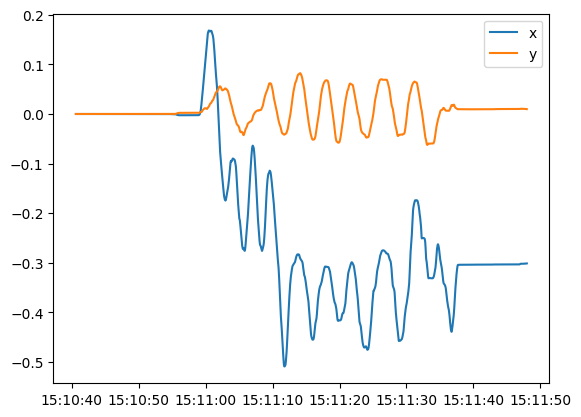

In [96]:
plt.plot(_sk_df["time"], _sk_df["x"], label="x")
plt.plot(_sk_df["time"], _sk_df["y"], label="y")
plt.legend()

Imu calculations

In [45]:
_imu_df = _sk_df[["time", "mils", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]].copy()
_imu_df = pl.from_pandas(_imu_df)
dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter

_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

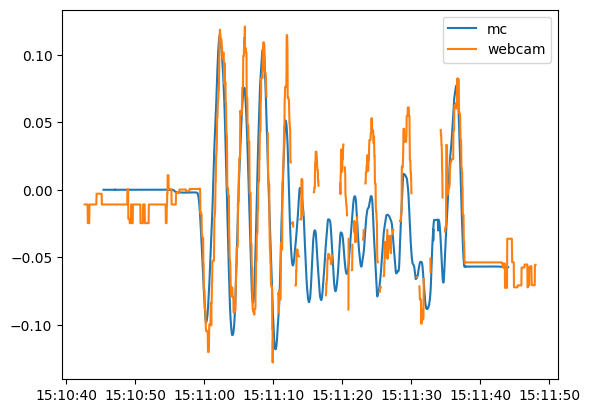

In [107]:
# plt.plot(_mocap_ar["time"], _mocap_ar["z"], label="mc")
# plt.plot(_w_df["time"], -_w_df["z"]+ 1.4, label="webcam")
# plt.plot(w_df["time"], savgol_filter(w_df["z"].values, 51, 1, mode='nearest') +0.05, label="webcam")
plt.plot(_mocap_sk["time"], _mocap_sk["y"], label="mc")
plt.plot(w_df["time"], ar_df["z"].rolling(5).median() - 1.3, label="webcam")
plt.legend()


In [47]:
w_df, _mocap_ar = trunkate_dfs(w_df, _mocap_ar)

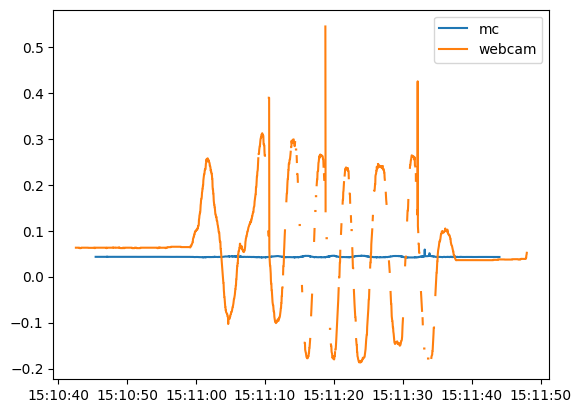

In [108]:
plt.plot(_mocap_ar["time"], _mocap_ar["y"], label="mc")
plt.plot(w_df["time"], w_df["x"], label="webcam")
plt.legend()

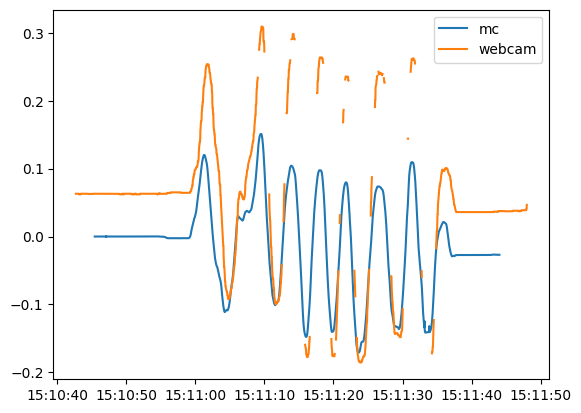

In [110]:
# plt.plot(_mocap_ar["time"], _mocap_ar["x"], label="mc x")
# plt.plot(w_df["time"], w_df["x"] + 0.015, label="webcam")
# plt.plot(_sk_df["time"], _sk_df["x"], label="sk")
plt.plot(_mocap_sk["time"], _mocap_sk["x"], label="mc")
plt.plot(ar_df["time"], ar_df["x"].rolling(5).median(), label="webcam")

plt.legend()